Roughly reproducing the simulator on the Washington Post
https://www.washingtonpost.com/graphics/2020/world/corona-simulator/

In [88]:
%matplotlib inline


In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as pl
import matplotlib as mpl
from numpy import random as rd
import time
import pickle as pk

In [102]:
n_agents = 100
transmission_threshold_distance = 0.08
transmission_factor = 1
recovery_days = 14
probability_of_mortality = 0.02

    
speed = 0.1
initial_infections = 1

status_colors = {0: 'blue', 1: 'brown', 2: 'pink', 3: 'black'}
def status_color(status):
    return status_colors[status]

def initialize_agents(n_agents, initial_infections):
    x_pos = [rd.uniform() for _ in range(n_agents)]
    y_pos = [rd.uniform() for _ in range(n_agents)]

    x_dir = [rd.uniform()*speed for _ in range(n_agents)]
    y_dir = [rd.uniform()*speed for _ in range(n_agents)]
    
    days_infected = [0 for _ in range(n_agents)]

    agent_order = rd.permutation(n_agents)

    agent_status = [0 for _ in range(n_agents)]
    # status 
    # 0 - uninfected
    # 1 - infected
    # 2 - recovered
    # 3 - mortality

    # create patient(s) zero
    for agent_index in agent_order[0:initial_infections]:
        agent_status[agent_index]  = 1
        days_infected[agent_index]  = 1
            
    agents = pd.DataFrame({'x pos': x_pos, 
                           'y pos': y_pos, 
                           'status': agent_status, 
                           'x dir': x_dir, 
                           'y dir': y_dir, 
                           'days infected': days_infected,
                           'color': [status_color(status) for status in agent_status],
                          })

    return agents

# def update
agents = initialize_agents(n_agents, initial_infections)

print(agents['status'].to_list())# eye-balling that there is one (or initial_infections) agent with status=1 and the rest zero
print()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]



In [103]:
"""
Two repeating events

1. Update infection statuses
    1a. Transmission 
        1a1. Check whether agents are within transmission distance
        1a2. Determine with infection transmits (v1 assume probability = 1, future model adjust probabilities). 
            Transmission rates/probabilities are relatedc to people's hygiene practices.
            E.g. use of gloves, washing of hands reduces transmission rates.
            
        1a3. Update status
        
    1b. Recovery (vs death)
        
        Update status
    
    1c. Death
        Probability based on factors: 
            age, 
            probability of being a smoker, 
            hospital load: hospital_capacity vs (current infected * probability of being hospitalized)
                probability of being covered = (USA: x %, rest of OECD: 1)
            +random factor
        
        
2. Movement    
        Update location of each agent
    Factors:
        social isolation: some % of agents do not move         


"""
None

In [104]:
def agents_are_close(threshold, agent1_x_pos, agent1_y_pos, agent2_x_pos, agent2_y_pos, verbose=False):
    
    distance = np.sqrt( (agent1_x_pos-agent2_x_pos) ** 2 + (agent1_y_pos-agent2_y_pos) ** 2 )
    
    if verbose:
        print(f"Distance: {distance}. Threshold: {threshold}. Close? {distance <= threshold}")
    
    return distance <= threshold


# test:
if not agents_are_close( 0.1, 0.8, 0.3, 0.81, 0.28 ):
    raise(ValueError("Distance function not working")) # Not really a value error. This should be implemented as a unit test.

In [105]:
def transmit_disease(agents_curr):
    agents = agents_curr.copy()
    
    agents.loc[:,'update as infected'] = False

    infected_agents = agents.loc[agents['status']==1,:]
    print(f"Number infected agents: {infected_agents.shape[0]}")
    
    # update infected status
    for agent1_index in range(n_agents):
        # 
        agent1 = agents.iloc[agent1_index]

        for agent2_index in range(infected_agents.shape[0]): #[:agent1_index]:
            agent2 = infected_agents.iloc[agent2_index]
            
            agents_close = agents_are_close( transmission_threshold_distance, 
                                            agent1['x pos'], 
                                            agent1['y pos'], 
                                            agent2['x pos'], 
                                            agent2['y pos'],
                                            verbose=False)            
            
            # future version, do a self merge for efficiency @TODO
            if agents_close \
                and rd.uniform() <= transmission_factor \
                and agent1['status'] == 0 \
                and agent2['status'] == 1 \
                and agent2['days infected'] <= recovery_days: # future, agent2 infected days between min and max 
                
                    print(f'Transmitting to agent {agent1_index}')
                    
                    agents.loc[agent1_index,'update as infected'] = True
                    #agents.loc[agent2_index,'update as infected'] = True

                    # future, update infection days count
                    # agents.loc[agent1_index,'days infected']
                    
    print(f"Number of new cases: {agents['update as infected'].sum()}")
                    
    # Assign infected status
    agents.loc[agents['update as infected'],'status'] = 1
    #agents.loc[agents['update as infected'],'color'] = [] # managed below
    agents.loc[agents['status']==1,'days infected'] = agents.loc[agents['status']==1,'days infected']+1
    
    # recovery - 
    survival = agents['status'].apply(lambda status: rd.uniform()>=probability_of_mortality )
    recovered = (agents['status']==1) & survival & (agents['days infected'] == 14)
    agents.loc[recovered,'status'] = 2
    
    fatality = (agents['status'] == 1) & (~survival) & (agents['days infected'] == 14)
    agents.loc[fatality,'status'] = 3 
    agents.loc[fatality,'x dir'] = 0
    agents.loc[fatality,'y dir'] = 0 # update marker to X
    
    #     
    agents['color'] = agents['status'].apply(status_color)
    
    return agents

In [106]:
#agents.head()
agents

print(agents.loc[agents['status']==1,:])

       x pos     y pos  status    x dir    y dir  days infected  color
90  0.966828  0.963889       1  0.04605  0.09404              1  brown


In [107]:
# agents

In [108]:
#transmit_disease(agents)

In [109]:
agent_state = []
agent_state.append(agents)
agent_state.append(transmit_disease(agents))

agent_state[1].loc[agent_state[1]['status']==1,:]

Number infected agents: 1
Transmitting to agent 16
Transmitting to agent 31
Number of new cases: 2


,x pos,y pos,status,x dir,y dir,days infected,color,update as infected
16,0.960910,0.947527,1,0.043648,0.032626,1,brown,True
31,0.969783,0.958307,1,0.049517,0.085698,1,brown,True
90,0.966828,0.963889,1,0.046050,0.094040,2,brown,False


In [110]:
adjust_outofrange = lambda pos, bounds: pos if (pos <= bounds[1] and pos >= bounds[0]) else (pos-1 if pos>bounds[1] else pos+1)

# def new_location(x_new, y_new, bounds):
#     # future, x1, y1, x2, y2, x_velocity, y_velocity
    
#     return (adjust_outofrange(x_new, [0,1]), adjust_outofrange(y_new, [0,1])) # too much engineering? Setting up for future new_location which could bound agents of bounds and other agents.
 
def move_agents(agents_orig):
    
    agents = agents_orig.copy()
    
    agents['x pos'] = agents['x pos'] + agents['x dir']
    agents['y pos'] = agents['y pos'] + agents['y dir']
    
    # update if outside of range - rather than "bouncing" off other agents, we assume that the continue to move within the space starting from the other extremee.
    agents['x pos'] = agents['x pos'].apply(lambda x: adjust_outofrange(x, [0,1]) )
    agents['y pos'] = agents['y pos'].apply(lambda x: adjust_outofrange(x, [0,1]) )
        
    return agents

In [111]:
# run simulation (100 iterations)
n_periods = 20

agent_state = []
agent_state.append(agents)
for period_i in range(n_periods):    
    print(f'period={period_i}')
    # transmit
    agent_state.append(transmit_disease(agent_state[-1]))
                       
    # move - reuse
    agent_state[-1] = move_agents(agent_state[-1])             
                       


period=0
Number infected agents: 1
Transmitting to agent 16
Transmitting to agent 31
Number of new cases: 2
period=1
Number infected agents: 3
Transmitting to agent 36
Transmitting to agent 36
Number of new cases: 1
period=2
Number infected agents: 4
Transmitting to agent 25
Transmitting to agent 25
Transmitting to agent 41
Transmitting to agent 41
Transmitting to agent 73
Number of new cases: 3
period=3
Number infected agents: 7
Transmitting to agent 81
Transmitting to agent 81
Transmitting to agent 94
Transmitting to agent 99
Number of new cases: 3
period=4
Number infected agents: 10
Transmitting to agent 17
Transmitting to agent 17
Transmitting to agent 18
Transmitting to agent 26
Transmitting to agent 46
Transmitting to agent 46
Transmitting to agent 47
Transmitting to agent 47
Transmitting to agent 51
Number of new cases: 6
period=5
Number infected agents: 16
Transmitting to agent 45
Transmitting to agent 96
Transmitting to agent 96
Number of new cases: 2
period=6
Number infected 

In [141]:
with open('data/simulation.pkl', 'wb' ) as file:
    pk.dump(agent_state, file)

In [15]:
len(agent_state)

11

In [112]:
agent_state[-1].loc[agent_state[-1]['status']>=1,:]

,x pos,y pos,status,x dir,y dir,days infected,color,update as infected
0,0.160217,0.277689,1,0.091760,0.081336,10,brown,False
1,0.258914,0.955154,1,0.037444,0.079894,10,brown,False
2,0.167714,0.122287,1,0.088097,0.084054,8,brown,False
3,0.422256,0.001086,1,0.051144,0.009011,7,brown,False
4,0.627674,0.958503,1,0.041293,0.009326,8,brown,False
5,0.352025,0.025297,1,0.037230,0.008262,8,brown,False
6,0.370371,0.340839,1,0.037169,0.045259,8,brown,False
7,0.889367,0.074658,1,0.099466,0.044733,13,brown,False
8,0.751362,0.341526,1,0.054159,0.022621,5,brown,False
9,0.567240,0.733501,2,0.017452,0.019411,14,pink,False


<Figure size 432x288 with 0 Axes>

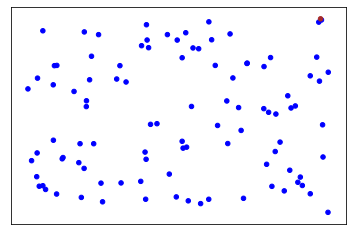

In [113]:
import matplotlib.animation as animation

def plot_agents(agents):
        
    fig = pl.figure()
    axes = agents.plot.scatter(
        x='x pos', 
        y='y pos', 
        c=agents['color'], 
        marker='o'
    ) # colormap
        
    pl.xticks([])    
    _ = pl.yticks([])    
    pl.xlabel("")
    pl.ylabel("")
    
    return (fig, axes)


fig, axes = plot_agents(agents)
scat = [child for child in axes.get_children() if type(child) is mpl.collections.PathCollection][0]

# https://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot
def update_plot(period, agent_state, scat):
    print(f'period={period}')
    
    scat.set_offsets(agent_state[period][['x pos','y pos']].to_numpy())

    return scat,
    
ani = animation.FuncAnimation(
                              fig, 
                              #init_func=lambda _:plot_agents(agents)
                              update_plot, 
                              frames=range(len(agent_state)),
                              fargs=(agent_state, scat), 
                              interval=1
)

#         self.ani = animation.FuncAnimation(self.fig, self.update, interval=5, 
#                                           init_func=self.setup_plot, blit=True)
pl.show()


0


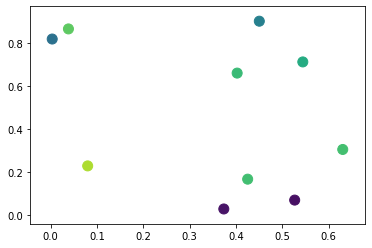

In [99]:
def update_plot(i, data, scat):
    print(i)
    scat.set_array(data[i])
    return scat,

def main():
    numframes = 100
    numpoints = 10
    color_data = np.random.random((numframes, numpoints))
    x, y, c = np.random.random((3, numpoints))

    fig = pl.figure()
    scat = pl.scatter(x, y, c=c, s=100)

    ani = animation.FuncAnimation(fig, update_plot, frames=40,
                                  fargs=(color_data, scat))
    pl.show()


main()

In [79]:
# for i in range(len(agent_state)):
#     print(i)

In [66]:
len(agent_state)

21

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


<Figure size 432x288 with 0 Axes>

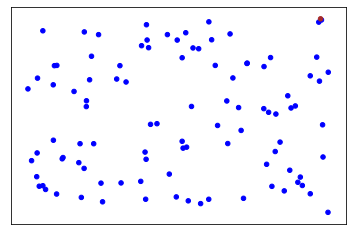

<Figure size 432x288 with 0 Axes>

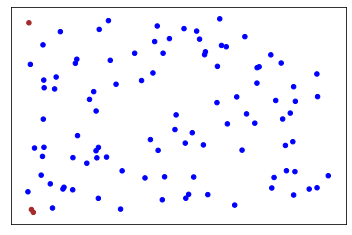

<Figure size 432x288 with 0 Axes>

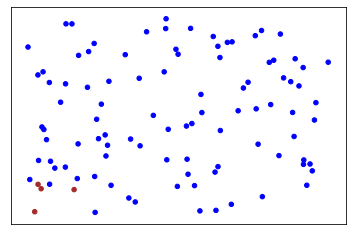

<Figure size 432x288 with 0 Axes>

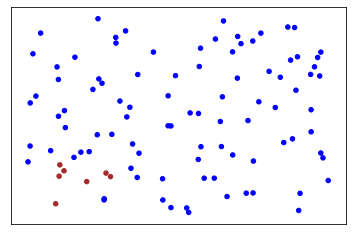

<Figure size 432x288 with 0 Axes>

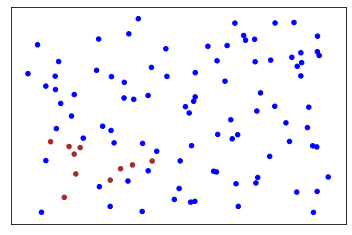

<Figure size 432x288 with 0 Axes>

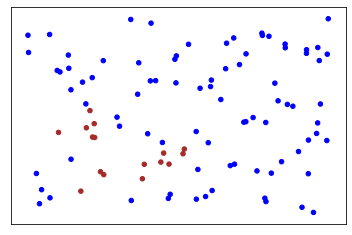

<Figure size 432x288 with 0 Axes>

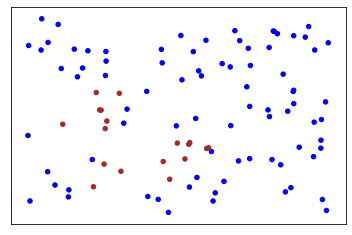

<Figure size 432x288 with 0 Axes>

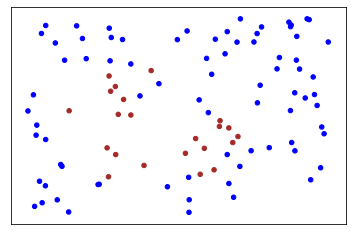

<Figure size 432x288 with 0 Axes>

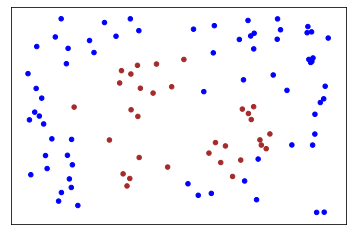

<Figure size 432x288 with 0 Axes>

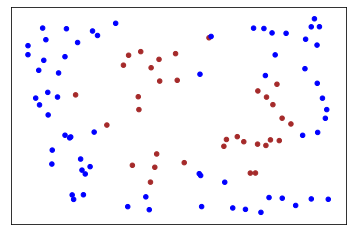

<Figure size 432x288 with 0 Axes>

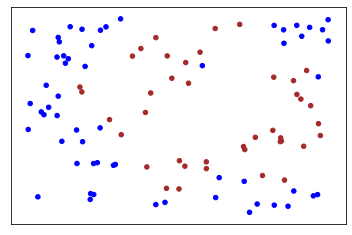

<Figure size 432x288 with 0 Axes>

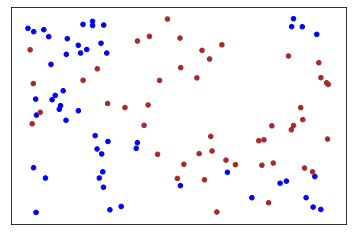

<Figure size 432x288 with 0 Axes>

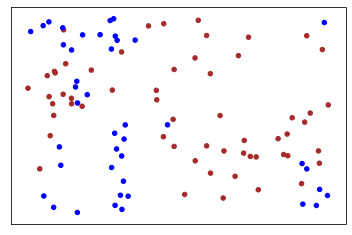

<Figure size 432x288 with 0 Axes>

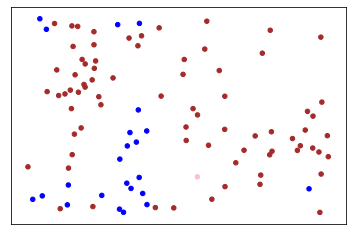

<Figure size 432x288 with 0 Axes>

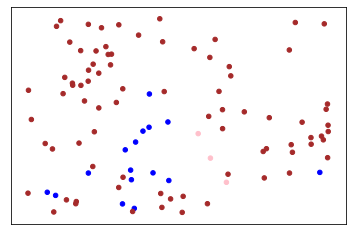

<Figure size 432x288 with 0 Axes>

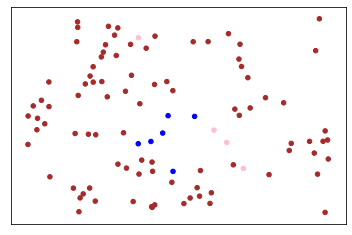

<Figure size 432x288 with 0 Axes>

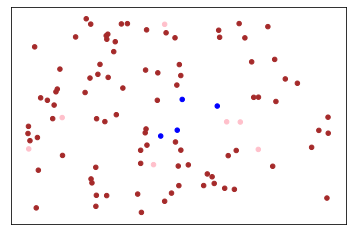

<Figure size 432x288 with 0 Axes>

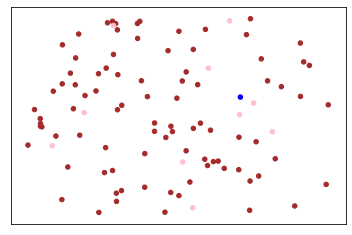

<Figure size 432x288 with 0 Axes>

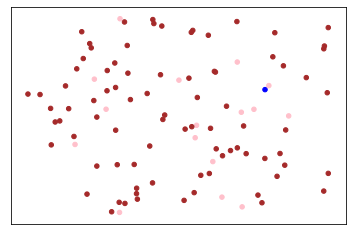

<Figure size 432x288 with 0 Axes>

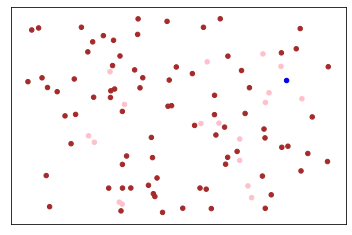

<Figure size 432x288 with 0 Axes>

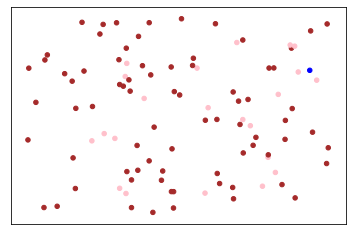

In [114]:
for i in range(len(agent_state)):
    plot_agents(agent_state[i])

In [163]:
#type(axes_children[0])
type(axes_children[0]) is mpl.collections.PathCollection

True

In [ ]:
plot_agents(agent_state)